In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import joblib

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# Fixer une graine aléatoire
RANDOM_STATE = 42
data=pd.read_csv("dataAssurance.csv")

In [25]:
df = pd.read_csv("dataAssurance.csv")

In [26]:
# Aperçu des premières lignes
print("Aperçu du dataset :")
display(df.head())

# Informations générales
print("\nInformations générales :")
print(df.info())

# Statistiques descriptives
print("\nStatistiques descriptives :")
display(df.describe(include="all"))

# Vérification des valeurs manquantes
print("\nValeurs manquantes par colonne :")
print(df.isna().sum())

Aperçu du dataset :


,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.92400
1,18.0,male,33.770,1.0,no,southeast,1725.55230
2,28.0,male,33.000,3.0,no,southeast,4449.46200
3,33.0,male,22.705,0.0,no,northwest,21984.47061
4,32.0,male,28.880,0.0,no,northwest,3866.85520



Informations générales :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1443 entries, 0 to 1442
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1406 non-null   float64
 1   sex       1405 non-null   object 
 2   bmi       1410 non-null   float64
 3   children  1414 non-null   float64
 4   smoker    1417 non-null   object 
 5   region    1410 non-null   object 
 6   charges   1414 non-null   float64
dtypes: float64(4), object(3)
memory usage: 79.0+ KB
None

Statistiques descriptives :


,age,sex,bmi,children,smoker,region,charges
count,1406.000000,1405,1410.000000,1414.000000,1417,1410,1414.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,719,NaN,NaN,1132,381,NaN
mean,39.179232,NaN,30.637681,1.086280,NaN,NaN,13179.307173
std,14.067120,NaN,6.112450,1.196088,NaN,NaN,11987.371506
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,26.000000,NaN,26.220000,0.000000,NaN,NaN,4748.057175
50%,39.000000,NaN,30.302500,1.000000,NaN,NaN,9369.615750
75%,51.000000,NaN,34.656250,2.000000,NaN,NaN,16547.261588



Valeurs manquantes par colonne :
age         37
sex         38
bmi         33
children    29
smoker      26
region      33
charges     29
dtype: int64


# Data **Understanding**


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
print("=== Dimensions du dataset ===")
print(f"Lignes : {df.shape[0]}, Colonnes : {df.shape[1]}")

print("\n=== Types de données ===")
print(df.dtypes)

print("\n=== Valeurs manquantes ===")
print(df.isna().sum())


=== Dimensions du dataset ===
Lignes : 1443, Colonnes : 7

=== Types de données ===
age         float64
sex          object
bmi         float64
children    float64
smoker       object
region       object
charges     float64
dtype: object

=== Valeurs manquantes ===
age         37
sex         38
bmi         33
children    29
smoker      26
region      33
charges     29
dtype: int64


In [29]:
# 2. Statistiques descriptives
print("\n=== Statistiques descriptives ===")
display(df.describe(include="all").T)



=== Statistiques descriptives ===


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,1406.0,NaN,NaN,NaN,39.179232,14.06712,18.0,26.0,39.0,51.0,64.0
sex,1405,2,male,719,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,1410.0,NaN,NaN,NaN,30.637681,6.11245,15.96,26.22,30.3025,34.65625,53.13
children,1414.0,NaN,NaN,NaN,1.08628,1.196088,0.0,0.0,1.0,2.0,5.0
smoker,1417,2,no,1132,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region,1410,4,southeast,381,NaN,NaN,NaN,NaN,NaN,NaN,NaN
charges,1414.0,NaN,NaN,NaN,13179.307173,11987.371506,1121.8739,4748.057175,9369.61575,16547.261588,63770.42801


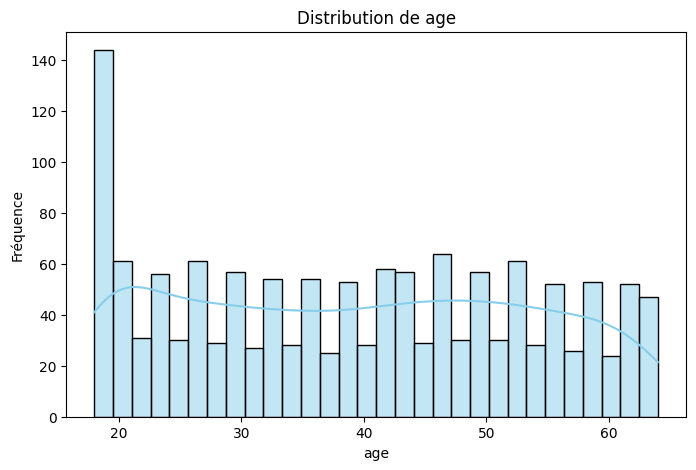

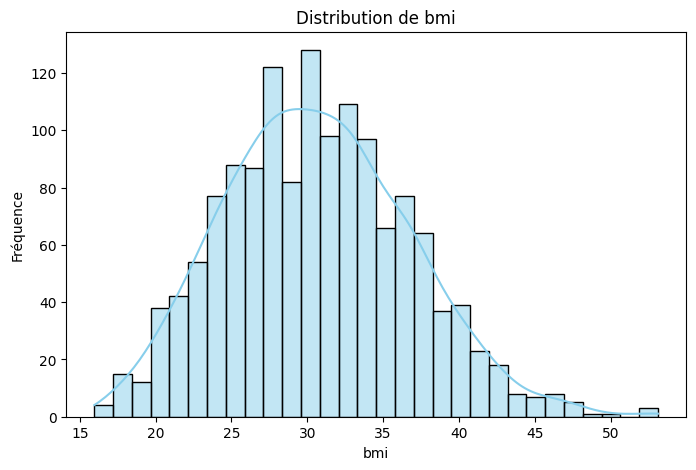

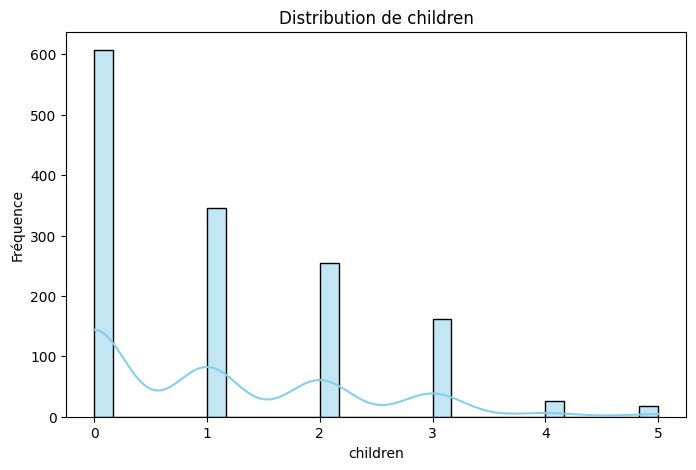

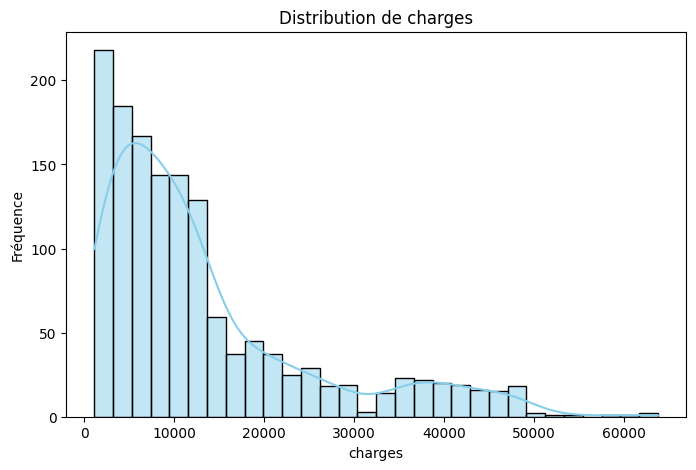

In [30]:
# 3. Distribution des variables numériques (histogrammes + KDE)
numeric_cols = ["age", "bmi", "children", "charges"]

for col in numeric_cols:
    plt.figure(figsize=(8,5))
    sns.histplot(df[col], kde=True, bins=30, color="skyblue")
    plt.title(f"Distribution de {col}")
    plt.xlabel(col)
    plt.ylabel("Fréquence")
    plt.show()

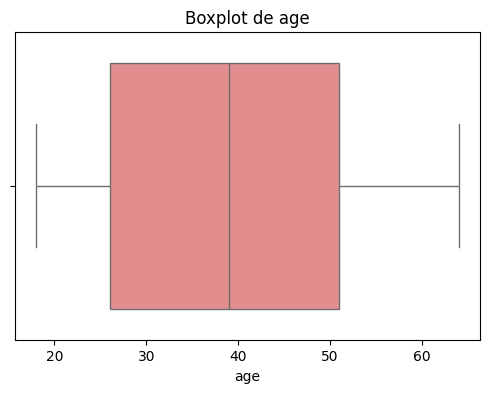

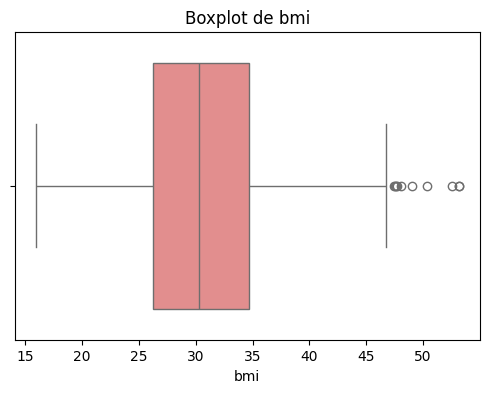

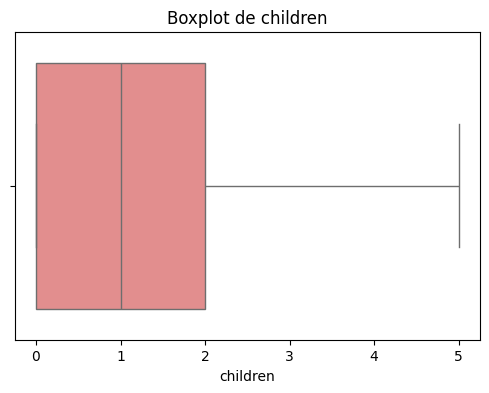

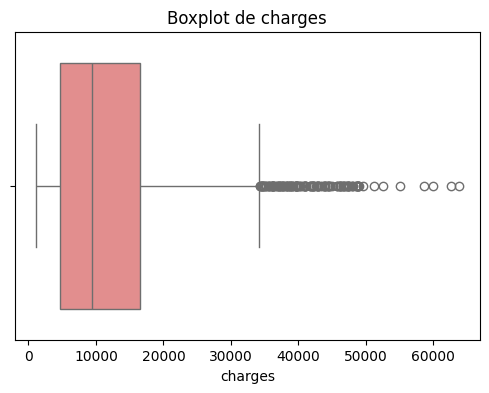

In [31]:
# 4. Boxplots pour détecter les valeurs extrêmes
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col], color="lightcoral")
    plt.title(f"Boxplot de {col}")
    plt.show()

In [32]:
# 5. Détection des outliers via les IQR (interquartiles)
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = series[(series < lower) | (series > upper)]
    return outliers, lower, upper

for col in numeric_cols:
    outliers, low, up = detect_outliers_iqr(df[col])
    print(f"\nColonne : {col}")
    print(f" - Q1 = {df[col].quantile(0.25):.2f}")
    print(f" - Q3 = {df[col].quantile(0.75):.2f}")
    print(f" - IQR = {df[col].quantile(0.75) - df[col].quantile(0.25):.2f}")
    print(f" - Limite basse = {low:.2f}, Limite haute = {up:.2f}")
    print(f" - Nb outliers détectés : {len(outliers)}")


Colonne : age
 - Q1 = 26.00
 - Q3 = 51.00
 - IQR = 25.00
 - Limite basse = -11.50, Limite haute = 88.50
 - Nb outliers détectés : 0

Colonne : bmi
 - Q1 = 26.22
 - Q3 = 34.66
 - IQR = 8.44
 - Limite basse = 13.57, Limite haute = 47.31
 - Nb outliers détectés : 10

Colonne : children
 - Q1 = 0.00
 - Q3 = 2.00
 - IQR = 2.00
 - Limite basse = -3.00, Limite haute = 5.00
 - Nb outliers détectés : 0

Colonne : charges
 - Q1 = 4748.06
 - Q3 = 16547.26
 - IQR = 11799.20
 - Limite basse = -12950.75, Limite haute = 34246.07
 - Nb outliers détectés : 145


/tmp/ipython-input-3359000227.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="Set3")


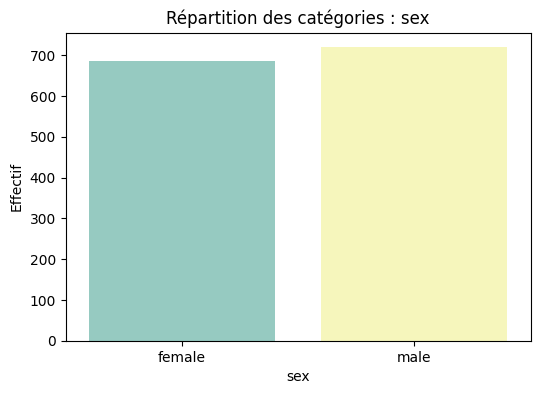

/tmp/ipython-input-3359000227.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="Set3")


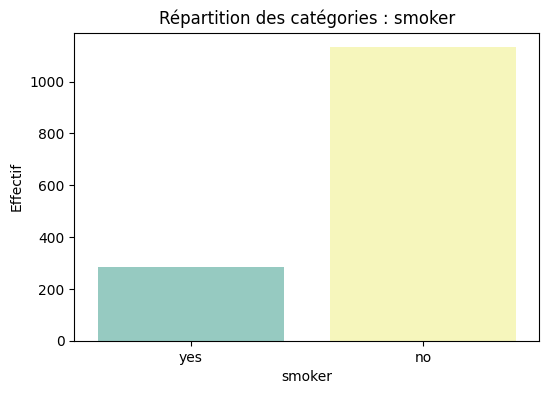

/tmp/ipython-input-3359000227.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="Set3")


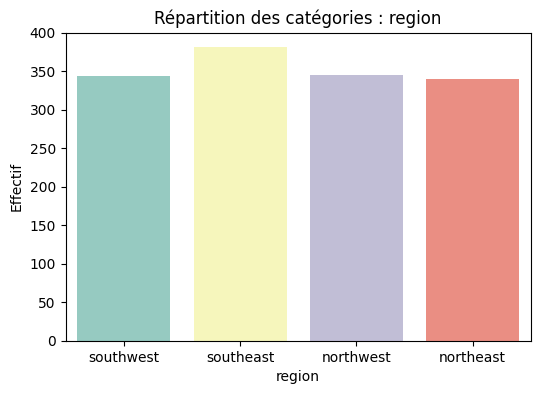

In [33]:
# 6. Variables catégorielles (répartition par barplot)
categorical_cols = ["sex", "smoker", "region"]

for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=df[col], palette="Set3")
    plt.title(f"Répartition des catégories : {col}")
    plt.xlabel(col)
    plt.ylabel("Effectif")
    plt.show()

/tmp/ipython-input-3355734255.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="smoker", y="charges", data=df, palette="Set2")


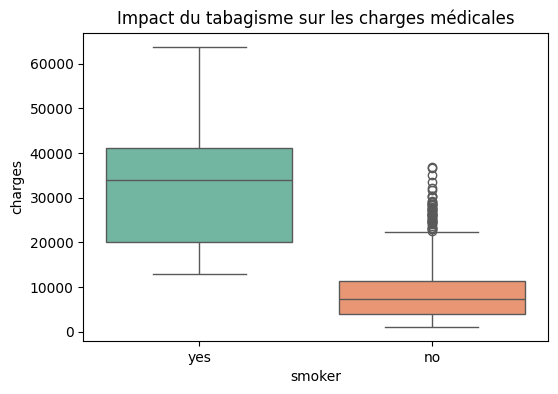

In [34]:
# 7. Relation charges vs fumeur
plt.figure(figsize=(6,4))
sns.boxplot(x="smoker", y="charges", data=df, palette="Set2")
plt.title("Impact du tabagisme sur les charges médicales")
plt.show()


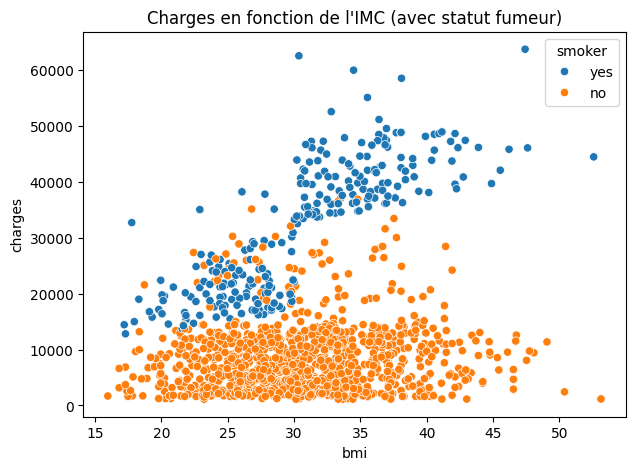

In [35]:
# 8. Relation charges vs IMC
plt.figure(figsize=(7,5))
sns.scatterplot(x="bmi", y="charges", hue="smoker", data=df)
plt.title("Charges en fonction de l'IMC (avec statut fumeur)")
plt.show()

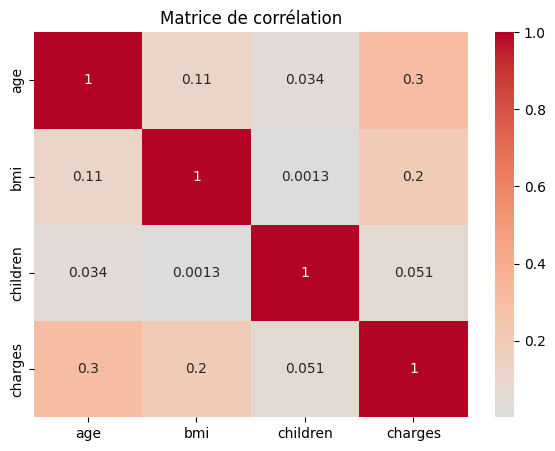

In [36]:
# 9. Matrice de corrélation (seulement variables numériques)
plt.figure(figsize=(7,5))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Matrice de corrélation")
plt.show()

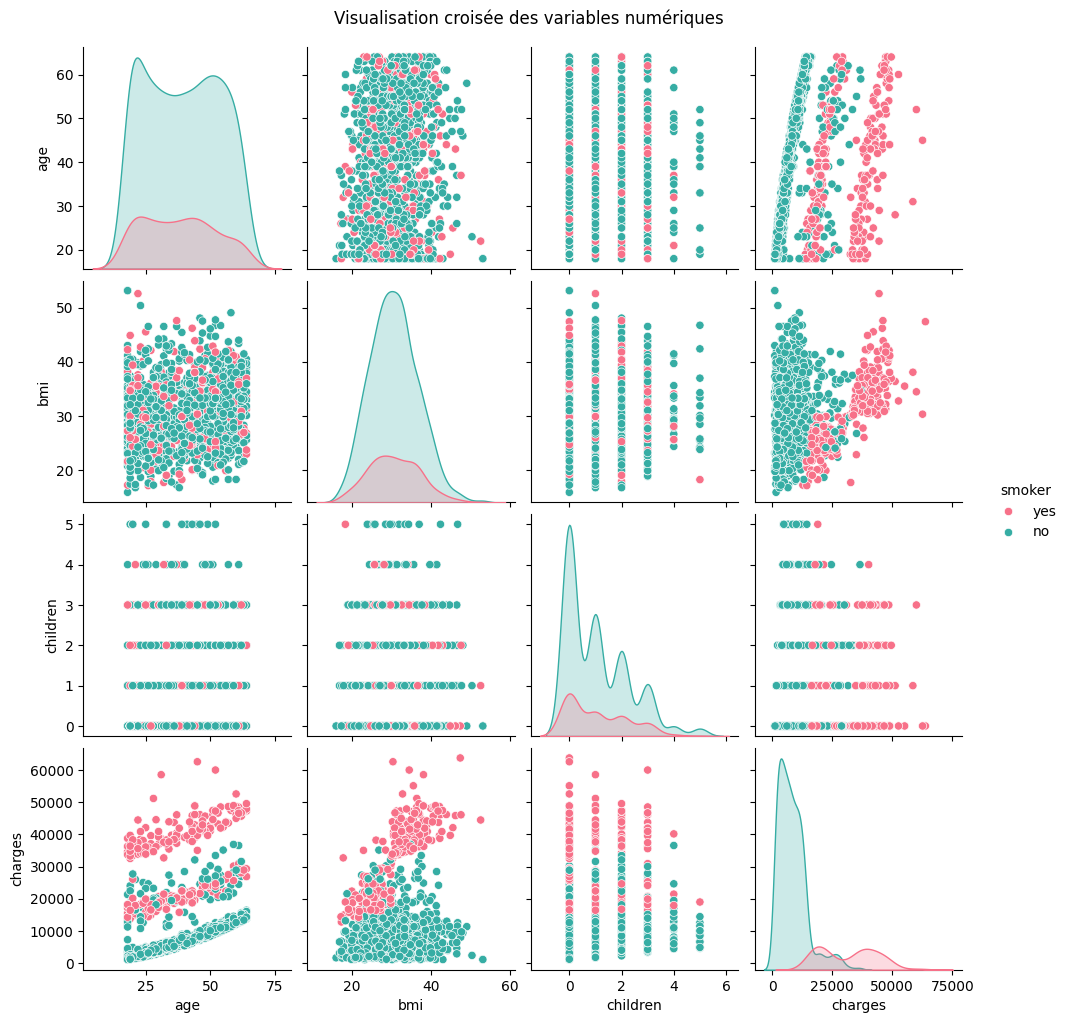

In [37]:
# 10. Pairplot (relation croisée entre variables)
sns.pairplot(df[numeric_cols + ["smoker"]], hue="smoker", diag_kind="kde", palette="husl")
plt.suptitle("Visualisation croisée des variables numériques", y=1.02)
plt.show()

# Data *Preparation*

In [38]:
# 1. Suppression des doublons
print("Taille avant suppression des doublons :", df.shape)
df = df.drop_duplicates()
print("Taille après suppression des doublons :", df.shape)


Taille avant suppression des doublons : (1443, 7)
Taille après suppression des doublons : (1338, 7)


In [39]:
# 2. Gestion des valeurs manquantes
# Ici, on peut choisir de supprimer ou d’imputer.
df = df.dropna()

In [40]:
# 3. Vérification des valeurs aberrantes simples (ex: âge négatif, BMI < 10 ou > 70)
df = df[df["age"] > 0]
df = df[(df["bmi"] >= 10) & (df["bmi"] <= 70)]

In [41]:
# 4. Création de deux jeux de variables :
# - FS_A : profil démographique et style de vie (sans charges)
# - FS_B : FS_A + variable charges

fs_a_features = ["age", "bmi", "children", "sex", "smoker", "region"]
fs_b_features = fs_a_features + ["charges"]


In [42]:
# Séparation numérique et catégorielle
def split_feature_types(columns, frame):
    num = [c for c in columns if np.issubdtype(frame[c].dtype, np.number)]
    cat = [c for c in columns if c not in num]
    return num, cat

num_a, cat_a = split_feature_types(fs_a_features, df)
num_b, cat_b = split_feature_types(fs_b_features, df)


In [43]:
# Préprocesseur pour FS_A
preprocess_a = ColumnTransformer([
    ("num", StandardScaler(), num_a),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_a),
])

# Préprocesseur pour FS_B
preprocess_b = ColumnTransformer([
    ("num", StandardScaler(), num_b),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_b),
])

## **#Modeling**

In [44]:


# Données d’entrée
X_a = df[fs_a_features]
X_b = df[fs_b_features]

# 1. Pipelines Isolation Forest
isoforest_a = Pipeline([
    ("prep", preprocess_a),
    ("model", IsolationForest(
        n_estimators=300,
        max_samples="auto",
        contamination=0.05,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

isoforest_b = Pipeline([
    ("prep", preprocess_b),
    ("model", IsolationForest(
        n_estimators=300,
        max_samples="auto",
        contamination=0.05,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

# 2. Pipelines One-Class SVM
ocsvm_a = Pipeline([
    ("prep", preprocess_a),
    ("model", OneClassSVM(kernel="rbf", gamma="scale", nu=0.05))
])

ocsvm_b = Pipeline([
    ("prep", preprocess_b),
    ("model", OneClassSVM(kernel="rbf", gamma="scale", nu=0.05))
])

# 3. Entraînement des modèles
print("Entraînement des modèles en cours...")

isoforest_a.fit(X_a)
isoforest_b.fit(X_b)

ocsvm_a.fit(X_a)
ocsvm_b.fit(X_b)

print("✅ Modèles entraînés avec succès (CRISP-DM jusqu'à Modélisation).")

# Sauvegarde des modèles (optionnel)
joblib.dump(isoforest_a, "isoforest_FS_A.joblib")
joblib.dump(isoforest_b, "isoforest_FS_B.joblib")
joblib.dump(ocsvm_a, "ocsvm_FS_A.joblib")
joblib.dump(ocsvm_b, "ocsvm_FS_B.joblib")


Entraînement des modèles en cours...
✅ Modèles entraînés avec succès (CRISP-DM jusqu'à Modélisation).


['ocsvm_FS_B.joblib']

In [45]:
# ================================
# ÉVALUATION GÉNÉRIQUE TOUS MODÈLES
# ================================

# 0) Prépare les jeux de features (adaptés à tes préprocess)
X_map = {
    "IF_A": X_a,
    "IF_B": X_b,
    "OCSVM_A": X_a,
    "OCSVM_B": X_b,
}

# 1) Regroupe les pipelines
models = {
    "IF_A": isoforest_a,
    "IF_B": isoforest_b,
    "OCSVM_A": ocsvm_a,
    "OCSVM_B": ocsvm_b,
}

# 2) Copie du DF résultats
df_results = df.copy()

# 3) Prédictions + Scores d’anomalie (comparables)
# Convention choisie: "anomaly_score" = plus grand => + anormal
for name, model in models.items():
    X = X_map[name]

    # Prédictions (+1 = normal, -1 = anomalie)
    preds = model.predict(X)
    df_results[f"{name}_pred"] = preds

    # Scores :
    # - IsolationForest: score_samples -> scores élevés = normal
    # - OneClassSVM: decision_function -> scores élevés = normal
    # On convertit pour avoir: plus grand => + ANORMAL
    if name.startswith("IF"):
        # plus petit = + anormal -> on inverse le signe
        raw_score = model.named_steps["model"].score_samples(
            model.named_steps["prep"].transform(X)
        )
        anomaly_score = -raw_score
    else:
        raw_score = model.named_steps["model"].decision_function(
            model.named_steps["prep"].transform(X)
        )
        anomaly_score = -raw_score  # idem : grand => anormal

    df_results[f"{name}_score"] = anomaly_score

# 4) Compter les anomalies par modèle
print("=== Nombre d’anomalies détectées (par modèle) ===")
for name in models.keys():
    n_anom = (df_results[f"{name}_pred"] == -1).sum()
    print(f"{name:10s}: {n_anom}")

# 5) Tableau récap (optionnel)
summary = []
for name in models.keys():
    summary.append({
        "model": name,
        "n_rows": len(df_results),
        "n_anomalies": int((df_results[f"{name}_pred"] == -1).sum()),
        "anomaly_rate_%": 100 * (df_results[f"{name}_pred"] == -1).mean()
    })
summary_df = pd.DataFrame(summary).sort_values("model")
display(summary_df)

# 6) EXEMPLES d’anomalies pour chaque modèle
for name in models.keys():
    print(f"\n=== Exemples d’anomalies ({name}) ===")
    ex = df_results[df_results[f"{name}_pred"] == -1] \
            .sort_values(f"{name}_score", ascending=False) \
            .head(10)
    display(ex)


=== Nombre d’anomalies détectées (par modèle) ===
IF_A      : 58
IF_B      : 58
OCSVM_A   : 65
OCSVM_B   : 62


,model,n_rows,n_anomalies,anomaly_rate_%
0,IF_A,1148,58,5.052265
1,IF_B,1148,58,5.052265
2,OCSVM_A,1148,65,5.662021
3,OCSVM_B,1148,62,5.400697



=== Exemples d’anomalies (IF_A) ===


,age,sex,bmi,children,smoker,region,charges,IF_A_pred,IF_A_score,IF_B_pred,IF_B_score,OCSVM_A_pred,OCSVM_A_score,OCSVM_B_pred,OCSVM_B_score
1085,39.0,female,18.300,5.0,yes,southwest,19023.26000,-1,0.675115,-1,0.658638,-1,1.634303,-1,1.448165
994,27.0,female,20.045,3.0,yes,northwest,16420.49455,-1,0.649904,-1,0.631290,1,-0.000023,1,-0.098487
1122,53.0,female,36.860,3.0,yes,northwest,46661.44240,-1,0.643092,-1,0.649632,1,-0.410678,1,-0.211073
1186,20.0,male,35.625,3.0,yes,northwest,37465.34375,-1,0.642158,-1,0.629876,-1,0.153410,-1,0.167049
250,18.0,male,17.290,2.0,yes,northeast,12829.45510,-1,0.640766,-1,0.611396,-1,0.421958,-1,0.344987
128,32.0,female,17.765,2.0,yes,northwest,32734.18630,-1,0.640326,-1,0.628513,-1,0.000427,-1,0.553693
1307,32.0,male,28.120,4.0,yes,northwest,21472.47880,-1,0.639999,-1,0.621906,1,-0.465525,1,-0.494135
494,21.0,male,25.700,4.0,yes,southwest,17942.10600,-1,0.637008,-1,0.623208,1,-0.000181,-1,0.000107
860,37.0,female,47.600,2.0,yes,southwest,46113.51100,-1,0.636477,-1,0.646261,-1,0.384880,-1,0.540995
281,54.0,male,40.565,3.0,yes,northeast,48549.17835,-1,0.634527,-1,0.636912,1,-0.000074,-1,0.036743



=== Exemples d’anomalies (IF_B) ===


,age,sex,bmi,children,smoker,region,charges,IF_A_pred,IF_A_score,IF_B_pred,IF_B_score,OCSVM_A_pred,OCSVM_A_score,OCSVM_B_pred,OCSVM_B_score
1085,39.0,female,18.300,5.0,yes,southwest,19023.26000,-1,0.675115,-1,0.658638,-1,1.634303,-1,1.448165
1122,53.0,female,36.860,3.0,yes,northwest,46661.44240,-1,0.643092,-1,0.649632,1,-0.410678,1,-0.211073
860,37.0,female,47.600,2.0,yes,southwest,46113.51100,-1,0.636477,-1,0.646261,-1,0.384880,-1,0.540995
94,64.0,female,31.300,2.0,yes,southwest,47291.05500,-1,0.633833,-1,0.644290,-1,0.000041,1,-0.000257
251,63.0,female,32.200,2.0,yes,southwest,47305.30500,-1,0.631984,-1,0.642446,1,-0.127516,1,-0.177748
328,64.0,female,33.800,1.0,yes,southwest,47928.03000,-1,0.631974,-1,0.642027,1,-0.184225,1,-0.141822
281,54.0,male,40.565,3.0,yes,northeast,48549.17835,-1,0.634527,-1,0.636912,1,-0.000074,-1,0.036743
1230,52.0,male,34.485,3.0,yes,northwest,60021.39897,-1,0.618437,-1,0.635061,1,-0.869562,-1,0.807961
1301,62.0,male,30.875,3.0,yes,northwest,46718.16325,-1,0.630341,-1,0.632949,-1,0.000393,1,-0.000069
994,27.0,female,20.045,3.0,yes,northwest,16420.49455,-1,0.649904,-1,0.631290,1,-0.000023,1,-0.098487



=== Exemples d’anomalies (OCSVM_A) ===


,age,sex,bmi,children,smoker,region,charges,IF_A_pred,IF_A_score,IF_B_pred,IF_B_score,OCSVM_A_pred,OCSVM_A_score,OCSVM_B_pred,OCSVM_B_score
438,52.0,female,46.750,5.0,no,southeast,12592.53450,-1,0.628033,1,0.593213,-1,2.382313,-1,2.017359
1085,39.0,female,18.300,5.0,yes,southwest,19023.26000,-1,0.675115,-1,0.658638,-1,1.634303,-1,1.448165
1317,18.0,male,53.130,0.0,no,southeast,1163.46270,1,0.569144,1,0.559986,-1,1.585098,-1,1.559741
640,33.0,male,42.400,5.0,no,southwest,6666.24300,-1,0.615745,1,0.590619,-1,1.372305,-1,1.032264
1047,22.0,male,52.580,1.0,yes,southeast,44501.39820,1,0.602666,-1,0.620087,-1,1.139123,-1,1.536112
116,58.0,male,49.060,0.0,no,southeast,11381.32540,1,0.555226,1,0.546726,-1,0.915929,-1,0.742170
166,20.0,female,37.000,5.0,no,southwest,4830.63000,-1,0.614208,1,0.584826,-1,0.821685,-1,0.578661
172,18.0,male,15.960,0.0,no,northeast,1694.79640,1,0.556859,1,0.547488,-1,0.521562,-1,0.458297
1074,60.0,female,18.335,0.0,no,northeast,13204.28565,1,0.554119,1,0.545427,-1,0.490920,-1,0.415841
984,20.0,male,30.115,5.0,no,northeast,4915.05985,1,0.600368,1,0.566496,-1,0.455750,-1,0.334278



=== Exemples d’anomalies (OCSVM_B) ===


,age,sex,bmi,children,smoker,region,charges,IF_A_pred,IF_A_score,IF_B_pred,IF_B_score,OCSVM_A_pred,OCSVM_A_score,OCSVM_B_pred,OCSVM_B_score
438,52.0,female,46.750,5.0,no,southeast,12592.53450,-1,0.628033,1,0.593213,-1,2.382313,-1,2.017359
1317,18.0,male,53.130,0.0,no,southeast,1163.46270,1,0.569144,1,0.559986,-1,1.585098,-1,1.559741
1047,22.0,male,52.580,1.0,yes,southeast,44501.39820,1,0.602666,-1,0.620087,-1,1.139123,-1,1.536112
1085,39.0,female,18.300,5.0,yes,southwest,19023.26000,-1,0.675115,-1,0.658638,-1,1.634303,-1,1.448165
640,33.0,male,42.400,5.0,no,southwest,6666.24300,-1,0.615745,1,0.590619,-1,1.372305,-1,1.032264
1230,52.0,male,34.485,3.0,yes,northwest,60021.39897,-1,0.618437,-1,0.635061,1,-0.869562,-1,0.807961
1012,61.0,female,33.330,4.0,no,southeast,36580.28216,1,0.575839,1,0.601665,-1,0.000024,-1,0.767275
116,58.0,male,49.060,0.0,no,southeast,11381.32540,1,0.555226,1,0.546726,-1,0.915929,-1,0.742170
577,31.0,female,38.095,1.0,yes,northeast,58571.07448,1,0.596790,-1,0.626795,1,-1.100841,-1,0.733274
166,20.0,female,37.000,5.0,no,southwest,4830.63000,-1,0.614208,1,0.584826,-1,0.821685,-1,0.578661


In [48]:
# =====================================================
# BLOC 6 : DASHBOARD INTERACTIF (PLOTLY)
# =====================================================
import plotly.express as px

# ⚠️ On part du DataFrame enrichi avec les colonnes anomalies (df_results)

# 1. Scatterplot interactif (BMI vs Charges)
fig1 = px.scatter(
    df_results,
    x="bmi", y="charges",
    color=(df_results["IF_A_pred"]==-1).map({True:"Anomalie", False:"Normal"}),
    hover_data=["age", "sex", "smoker", "region", "children"],
    title="Détection d’anomalies (Isolation Forest, FS_A)",
    color_discrete_map={"Normal":"green", "Anomalie":"red"}
)
fig1.show()

# 2. Barplot interactif : anomalies par région
df_results["anomaly_flag"] = (df_results["IF_A_pred"]==-1).map({True:"Anomalie", False:"Normal"})
fig2 = px.histogram(
    df_results,
    x="region", color="anomaly_flag",
    barmode="group",
    title="Nombre d’anomalies par région"
)
fig2.show()

# 3. Barplot interactif : anomalies par sexe
fig3 = px.histogram(
    df_results,
    x="sex", color="anomaly_flag",
    barmode="group",
    title="Nombre d’anomalies par sexe"
)
fig3.show()


In [50]:
# ============================================================
# CELLULE TEST : appliquer IF/OCSVM sur un exemple d’assuré
# (à placer APRÈS l’entraînement des pipelines isoforest_a/b et ocsvm_a/b)
# ============================================================

import pandas as pd

# 1) Définir un exemple d’assuré (adapte librement les valeurs)
example = {
    "age": 45,            # numérique
    "bmi": 25.0,          # numérique
    "children": 0,        # numérique
    "sex": "female",      # catégorielle
    "smoker": "yes",       # catégorielle ("yes"/"no" selon ton dataset)
    "region": "southeast",# catégorielle (par ex.: northeast/southeast/southwest/northwest)
    "charges": 40000.0    # numérique (UTILISÉ uniquement par FS_B)
}

# 2) Construire les DataFrames d’entrée dans l’ordre des features
#    - FS_A = profil sans "charges" -> fs_a_features
#    - FS_B = FS_A + "charges"      -> fs_b_features
x_a = pd.DataFrame([example])[fs_a_features]
x_b = pd.DataFrame([example])[fs_b_features]

# 3) Prédictions et scores pour chaque pipeline
#    Rappel: .predict(...) renvoie +1 (normal) ou -1 (anomalie)
#    decision_function(...) : plus négatif => plus atypique
res = {}

# --- Isolation Forest (FS_A) ---
pred_if_a = isoforest_a.predict(x_a)[0]
# decision_function est centré: >0 normal, <0 anomalie (plus négatif => plus anormal)
score_if_a = isoforest_a.named_steps["model"].decision_function(
    isoforest_a.named_steps["prep"].transform(x_a)
)[0]
res["IF_A"] = {"pred": int(pred_if_a), "decision_function": float(score_if_a)}

# --- Isolation Forest (FS_B) ---
pred_if_b = isoforest_b.predict(x_b)[0]
score_if_b = isoforest_b.named_steps["model"].decision_function(
    isoforest_b.named_steps["prep"].transform(x_b)
)[0]
res["IF_B"] = {"pred": int(pred_if_b), "decision_function": float(score_if_b)}

# --- One-Class SVM (FS_A) ---
pred_oc_a = ocsvm_a.predict(x_a)[0]
# decision_function: >0 proche du "support" (normal), <0 hors support (anomalie)
score_oc_a = ocsvm_a.named_steps["model"].decision_function(
    ocsvm_a.named_steps["prep"].transform(x_a)
)[0]
res["OCSVM_A"] = {"pred": int(pred_oc_a), "decision_function": float(score_oc_a)}

# --- One-Class SVM (FS_B) ---
pred_oc_b = ocsvm_b.predict(x_b)[0]
score_oc_b = ocsvm_b.named_steps["model"].decision_function(
    ocsvm_b.named_steps["prep"].transform(x_b)
)[0]
res["OCSVM_B"] = {"pred": int(pred_oc_b), "decision_function": float(score_oc_b)}

# 4) Affichage lisible
print("=== Exemple testé ===")
print(example)
print("\n=== Résultats (pred=+1 normal, -1 anomalie) ===")
for k, v in res.items():
    print(f"{k:9s} -> pred: {v['pred']:>2d} | decision_function: {v['decision_function']:.4f}")

# 5) Interprétation rapide (optionnelle)
#    Si tu veux agréger un "score global", tu peux par exemple sommer/faire la moyenne
#    des indicateurs binaires d'anomalie (pred == -1) :
anom_votes = sum(1 for m in res.values() if m["pred"] == -1)
print(f"\nVotes d'anomalie (sur 4 modèles): {anom_votes}/4")


=== Exemple testé ===
{'age': 45, 'bmi': 25.0, 'children': 0, 'sex': 'female', 'smoker': 'yes', 'region': 'southeast', 'charges': 40000.0}

=== Résultats (pred=+1 normal, -1 anomalie) ===
IF_A      -> pred:  1 | decision_function: 0.0327
IF_B      -> pred:  1 | decision_function: 0.0219
OCSVM_A   -> pred:  1 | decision_function: 0.8028
OCSVM_B   -> pred: -1 | decision_function: -0.0144

Votes d'anomalie (sur 4 modèles): 1/4


In [51]:
!git clone -b feature/anomaly-detection-isoforest-ocsvm https://github.com/yosriawedi/ML-Project-Insurance.git


Cloning into 'ML-Project-Insurance'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 37 (delta 12), reused 4 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (37/37), 567.26 KiB | 8.22 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [ ]:
from google.colab import files
uploaded = files.upload()
